Acceleromter Stuff
====
Initial investigation

In [1]:
""" Find the right file """
import pathlib

device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

# Check IDs are the right length
assert len(str(device_id)) == 7
assert len(str(recording_id)) == 10

# TODO Check that the participant agreed to take part in the study
# Do this by opening "Z:\SEACO data\SEACO-CH20 qnaire data\SEACO_CH20_17082022_de_id.csv"
# as a dataframe, finding the row with participant_id = df["residents_id"] and checking
# that the value of "respondent_status" here == 1
# I've checked the one above by hand and it's fine
...

filename = f"{device_id}_{recording_id}-{participant_id}.cwa"
# Windows path to RDSF mount on Z:
# Let's hope it's in the Week 1 folder
filepath = pathlib.Path(fr"Z:\SEACO data\Downloads\AX6 Activity Monitor\Week 1\{filename}")

# TODO add some code to look for the right file in all the "Week X" folders

assert filepath.exists()

In [2]:
""" Open this file """
from openmovement.load import CwaData

with CwaData(str(filepath), include_accel=True, include_gyro=True) as cwa_data:
    samples = cwa_data.get_samples()

In [10]:
""" Get the moving averages of acceleration and times """
import datetime
import numpy as np
from scipy.signal import convolve

times = samples["time"]
accel = np.sqrt(np.add.reduce([samples[f"accel_{p}"] ** 2 for p in ("x", "y", "z")]))

# Smooth dates and times
def moving_avg(array: np.ndarray, width: int):
    """ Use FFT to convolve an array with a rectangular window """
    return convolve(array, np.ones(width) / width, method="fft", mode="valid")

# 100Hz data rate so if we make the window 500 elements then we've got 5 second averages
width = 500

# Acceleration is just a number
smooth_accel = moving_avg(accel, 500)

# Times are datetime objects so we need to do something more complicated
# Get the first time, get the time deltas from this in ms, find the moving avg of time deltas and then add this back to the initial time
initial_time = times[0]
timedeltas = (times - initial_time) / datetime.timedelta(milliseconds=1)

smooth_deltas = moving_avg(timedeltas, 500)
smooth_times = initial_time + datetime.timedelta(milliseconds=1) * smooth_deltas


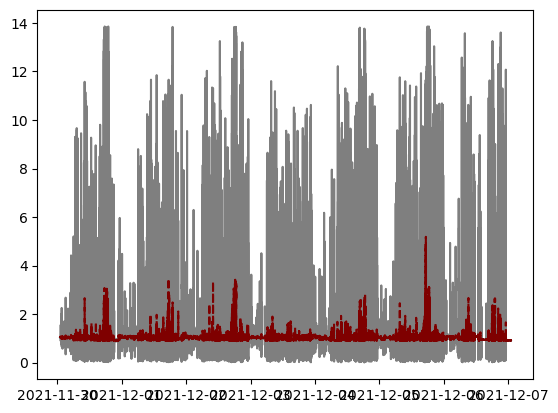

In [11]:
""" Plot the smoothed times """
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(15, 5))
plt.plot(smooth_times, smooth_accel, "r--")
plt.plot(times, accel, "k", alpha=0.5)

plt.show()

In [ ]:
""" Plot the overall magnitude of the accelration as a function of time """
fig, axes = plt.subplots(figsize=(12, 4))
axes.plot(times, accel)

# Set axis label rotation
labels = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")

# Shade nights (10pm-6am)
dates = [label.get_text() for label in labels]

sunrise = [datetime.datetime.strptime(date + "06", r"%Y-%m-%d%H") for date in dates]
sunset = [datetime.datetime.strptime(date + "22", r"%Y-%m-%d%H") for date in dates]

for start, end in zip(sunset, sunrise):
    ylim = axes.get_ylim()
    axes.fill_betweenx(ylim, [start - datetime.timedelta(days=1)] * 2, [end] * 2, color="r", alpha=0.3)
    axes.set_ylim(ylim)

axes.set_ylabel("Total acceleration")

fig.tight_layout()

In [ ]:
""" Show also meal times """
fig